# Exercice
**Determination of the metallicity and projected rotation velocity of the nearby solar type star HD4308.**

### Required libraries 
numpy, matplotlib, astropy, corner + an MCMC sampler of your choice (emcee, sam, ...)

### Introduction
High Resolution spectra of solar type stars allow to compute the Cross Correlation Function (CCF) of the spectrum of the star with respect to a template built using a Sun very high signal to noise and high resolution spectrum.

The resulting CCF can be seen as an "average stellar absorption line".
It contains several interesting information about the star.
The center of this CCF gives information about the radial velocity of the star with respect to the observer (Doppler effect).
The depth (or contrast) and the width of the CCF give informations about the projected stellar rotation velocity ($v\sin i$),
as well as the metallicity content of the star (FeH).

The relation between the contrast and width measured on the CCF and the stellar properties ($v\sin i$ and FeH) is not simple.
However, empirical relations based on the $B-V$ color index of the star have been obtained.

In this problem, you will derive the $v\sin i$ and metallicity of HD4308 which is a G6 dwarf, with color index $B-V=0.641$ in two steps:
- You will adjust a model on the CCF of this star in order to determine its basic properties (center, width, contrast). You will use a MCMC algorithm in order to sample the probability distribution of these parameters.
- You will use the provided empirical relations to derive the $v\sin i$ and metallicity (and their distributions).

### Loading data (nothing to do here)
We load the data from the HD4308_CCF.csv and plot it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import corner
import emcee

Text(0.5, 1.0, 'HD4308')

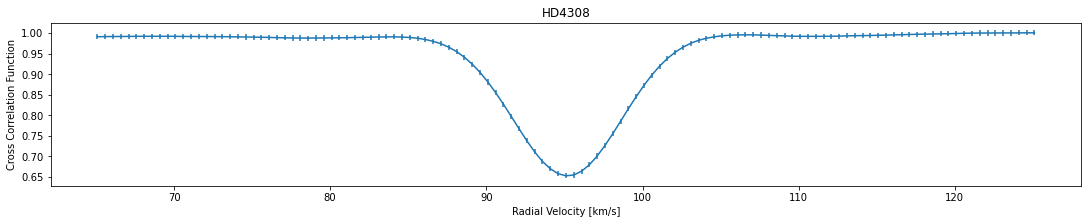

In [2]:
data = ascii.read('HD4308_CCF.csv', data_start=2, delimiter=';')
BmV=0.641
Ncor=len(data['rv'])

fig, ax1 = plt.subplots(1, 1, figsize=(15, 3), constrained_layout=True)
ax1.errorbar(data['rv'], data['ccf'], data['ccfErr'])
ax1.set_xlabel('Radial Velocity [km/s]')
ax1.set_ylabel('Cross Correlation Function')
ax1.set_title('HD4308')

### Question 1)

As you can see in the plot above, the CCF has been computed as a function of the velocity $v$.
For each velocity $v_i$ in the vector data['rv'], we provide the CCF value (CCF$(v_i)$)
as well as its uncertainty, in the vectors data['ccf'] and data['ccfErr'].\
The noise is assumed to be gaussian and independent.

In order to determine the center ($v_0$), width ($w$) and contrast ($c$) of the CCF,
you will model it with a Gaussian curve:
$$ f(v) = 1 - c \exp\left(-\frac{1}{2}\frac{(v-v_0)^2}{w^2}\right). $$

This model has already been implemented in the "ccf_model" function below.

**a) Write the "loglikelihood" function below.**

We assumed uniform priors for each parameter ($v_0$, $w$ and $c$), and implemented the corresponding "logprior" function.

**b) Write the "logprobability" function below.**

In [3]:
vmin = np.min(data['rv'])
vmax = np.max(data['rv'])
Dv = vmax-vmin
dv = Dv/data['rv'].size

def ccf_model(param):
    contrast, v0, width = param
    return(1 - contrast * np.exp(-0.5*((data['rv'] - v0)/width)**2))

def logprior(param):
    contrast, v0, width = param
    if contrast < 0 or contrast > 1:
        return(-np.inf)
    lp = 0
    if v0 < vmin or v0 > vmax:
        return(-np.inf)
    lp -= np.log(Dv)
    if width < 4*dv or width > Dv/2:
        return(-np.inf)
    lp -= np.log(Dv/2 - 4*dv)
    return(lp)


def loglikelihood(param):
    ################### TODO ###################
    y = data['ccf']
    ye = data['ccfErr']
    ff = ccf_model(param)
    lp = ((y-ff)/ye)**2
    l1 = -0.5*np.sum(lp)
    return l1
           
def logprobability(param):
    ################### TODO ###################
    bb = logprior(param) + loglikelihood(param)
    return bb

### Question 2)

Now that you have defined the "logprobability" function, you can run a MCMC algorithm to explore the parameter space.
We let you choose which algorithm to use (emcee, sam, etc.).
Do not forget to **import** it first.

We provide below a **very crude** guess of the parameters in order to initialize the MCMC.

In [4]:
# Initialize model parameters
paramInit = np.empty(3)
paramInit[0] = 1.-np.min(data['ccf']) # contrast (depth)
paramInit[1] = data['rv'][np.where(data['ccf']==np.min(data['ccf']))[0][0]] # center
paramInit[2] = np.ptp(data['rv'][data['ccf']<(1-paramInit[0]/2)])*0.5 # width

Text(0, 0.5, 'residuals')

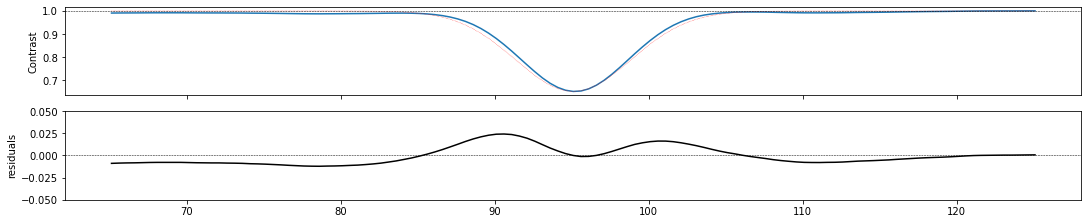

In [5]:
# Plot the corresponding model and residuals
fig, axs = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(15, 3), constrained_layout=True)
axs[0].plot(data['rv'], data['ccf'])
axs[0].plot(data['rv'], ccf_model(paramInit), 'r', linewidth=0.5, linestyle=':')
axs[0].axhline(1, linestyle='--', linewidth=0.5, color='black')
axs[0].set_ylabel('Contrast')
axs[1].plot(data['rv'],  data['ccf']-ccf_model(paramInit), 'k')
axs[1].axhline(0, linestyle='--', linewidth=0.5, color='black')
axs[1].set_ylim((-0.05, 0.05))
axs[1].set_ylabel('residuals')

**a) Use the MCMC algorithm of your choice to sample the posterior distribution of the parameters**

In [6]:
################### TODO ###################
nwalkers, ndim = 32, 3

posInit = paramInit * np.random.randn(nwalkers,ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprobability)
sampler.run_mcmc(posInit, 10000, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/jayshil/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [01:07<00:00, 148.55it/s]


State([[ 1.60976546e-01  1.02248719e+01 -4.27579764e+00]
 [ 2.45460953e-01 -8.94611757e+01  1.79796360e+00]
 [ 3.46104353e-01  9.51860962e+01  3.46525356e+00]
 [ 2.51835103e-02 -2.41836573e+01 -9.05726694e-01]
 [ 6.59099792e-01 -8.32547715e+01 -4.47994619e+00]
 [ 3.49027968e-01  9.51254027e+01  3.47301826e+00]
 [-2.31302708e-01 -8.92707632e+01 -6.94415375e+00]
 [ 3.50986289e-01  9.51573299e+01  3.46991937e+00]
 [ 3.43493992e-01  9.51866573e+01  3.50017093e+00]
 [ 1.88668274e-01 -8.72619202e+01 -5.41442358e+00]
 [ 3.49091428e-01  9.51572846e+01  3.48339429e+00]
 [ 2.05586104e-02 -6.84601473e+01 -5.51916614e+00]
 [ 2.85338415e-01  8.80737222e+01 -4.62644796e+00]
 [ 3.46714939e-01  9.51625940e+01  3.48964985e+00]
 [-4.36530809e-02 -1.25386532e+01  5.21512953e+00]
 [-4.47852381e-01 -2.78153995e+01 -3.42195546e-01]
 [ 7.92814961e-02  1.21826641e+02 -1.07659786e+00]
 [ 3.46676680e-01  9.52298106e+01  3.51059095e+00]
 [-3.16903556e-01 -4.93961883e+01  5.53939217e+00]
 [ 5.77817180e-01 -4.8071

**b) Plot the MCMC chains and comment. Define the samples that can be used to conduct a statistical analysis.**

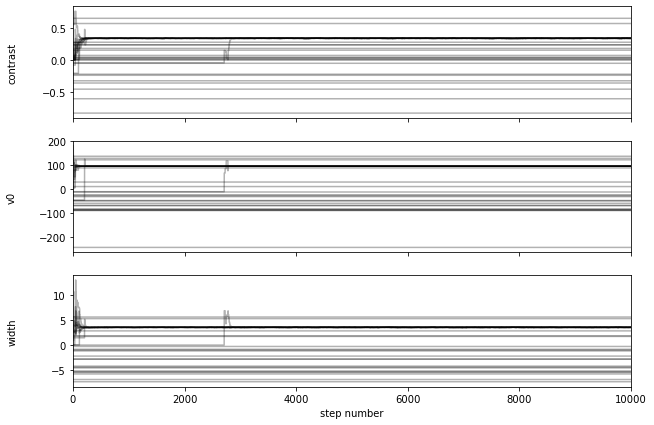

In [7]:
################### TODO ###################
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['contrast', 'v0', 'width']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Samples after first ~2000 can be used for statistical analysis after the chains become stable.

**c) Display a corner plot of the samples and comment. Which parameters are correlated?**

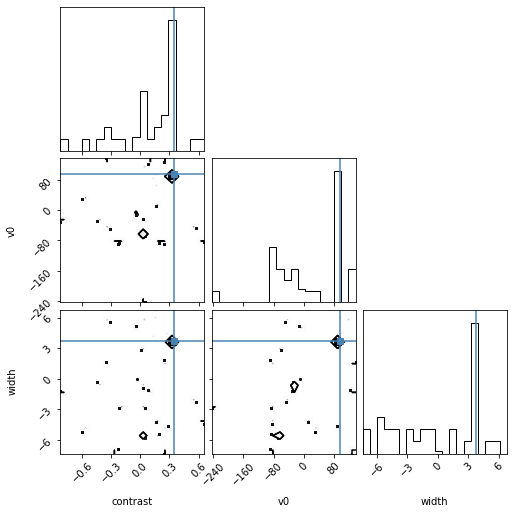

In [8]:
################### TODO ###################
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, truths=[paramInit[0], paramInit[1], paramInit[2]]
);

Although there are some scatter in the values, large part of the values are centered on the initial estimates. Since the distribution is too much centered on the value, we are not able to see any correlation.

### Question 3)

The final step is to apply the empirical relations to derive the metallicity and rotational velocity of the star.

We provide the two functions below that implement these empirical relations.

In [9]:
def computeFeH(width, contrast, BmV):
    #Empirical relation that relates the CCF parameters to the stellar metallicity
    a, b, c, d = -0.013, 4.798, -5.197, 2.161 # coeff FeH.

    #CCF peak equivalent width
    W_kmps = width * contrast * np.sqrt(2 * np.pi) 
    
    FeH = a + b*np.log10(W_kmps) + c*BmV + d*BmV**2
    return(FeH)

def computeVsini(width, BmV):
    Ar, e, f, g, h = 1.579, -3.328, 10.265, -9.467, 5.991  # coeff for vsini.
    ccfFwhm_kmps = 2*np.sqrt(2*np.log(2))*width
    sig0_kmps = e + f*BmV + g*BmV**2 + h*BmV**3
    vsini = Ar*np.sqrt(width**2 - sig0_kmps**2)
    return(vsini)

**a) Use these functions to derive the probability distributions of the metallicity and rotational velocity**

In [10]:
################### TODO ###################
cont = flat_samples[:,0]
v0 = flat_samples[:,1]
wid = flat_samples[:,2]

meta = computeFeH(wid, cont, v0)
velo = computeVsini(wid, v0)

/home/jayshil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/jayshil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


 **b) Compute the mean, median and standard deviation of these stellar properties**

In [11]:
################### TODO ###################
print(np.mean(meta), np.median(meta), np.std(meta))
print(np.mean(velo), np.median(velo), np.std(velo))

nan nan nan
nan nan nan


**c) Display a corner plot of these two parameters, comment. Are these parameters correlated?
Compute the covariance and the correlation between FeH and vsini.**

ValueError: supplied range of [nan, nan] is not finite

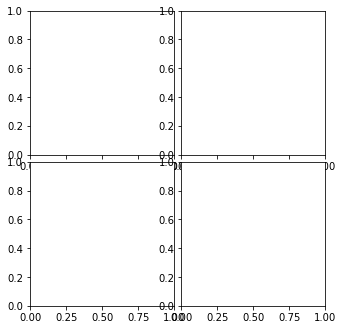

In [12]:
################### TODO ###################
data1 = np.vstack((meta, velo))
data = np.transpose(data1)
figure = corner.corner(data)